### Install the TensorFlow Model Garden pip package


In [1]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 50.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.10 requi

### Imports

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

print(tf.__version__)

2.8.4


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're us

### Recursos

Este diretório contém a configuração, o vocabulário e um ponto de verificação pré-treinado:

In [3]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

You can get a pre-trained BERT encoder from [TensorFlow Hub](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2):

In [4]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

##Os Dados

In [5]:
import json
import os
import pandas as pd

filename_save = '/content/review_data_Cyberpunk_2077.json'

if os.path.exists(filename_save):
  with open(filename_save, encoding='utf-8') as f:
    review_data = json.load(f)

reviews_df = pd.DataFrame(review_data)

reviews_df.sample(5)

,id,rating,review
1289,95300683,recomendado,"DO YOU REALLY HAVE TO PLAY THE SONG SO MUCH, G..."
118,260432083,recomendado,"Steam says I only have 1/2 an hour, but that's..."
1381,191092564,recomendado,"""How's 2020 so far?"" ""Kobe died"" ""Australia ..."
3227,1069597249,não recomendado,Don't buy game right now it has few problems:-...
3641,386510766,não recomendado,really upset that this was such a let down


In [6]:
from sklearn.model_selection import train_test_split

reviews_train, temp_df = train_test_split(reviews_df, test_size=0.4, random_state=11)

reviews_validation, reviews_test = train_test_split(temp_df, test_size=0.5, random_state=11)

In [7]:
def convert_to_dict_format(data):
  one_hot_code = {
    'não recomendado': 0,
    'recomendado': 1
  }
  reviews = []
  labels = []
  for i in range(len(data)):
    reviews.append(data.iloc[i]['review'])
    labels.append(one_hot_code[data.iloc[i]['rating']])


  return {'reviews': reviews, 'labels':labels}

In [8]:
reviews_train = convert_to_dict_format(reviews_train)
reviews_validation = convert_to_dict_format(reviews_validation)
reviews_test = convert_to_dict_format(reviews_test)

### The BERT tokenizer

Para ajustar um modelo pré-treinado, você precisa ter certeza de que está usando exatamente a mesma tokenização, vocabulário e mapeamento de índice que usou durante o pré-treinamento.

O código a seguir reconstrói o tokenizador que foi usado pelo modelo base:

In [9]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


Tokenizar uma frase:

In [10]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


### Pré-processar os dados

Vamos pré-processar manualmente o conjunto de dados no formato esperado pelo modelo.

#### Intuições para a convicção de sentenças

Espera-se que esta entrada comece com um token `[CLS]` "Este é um problema de classificação" e cada frase deve terminar com um token `[SEP]` "Separador":

In [11]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Comece codificando todas as frases, acrescentando um token `[SEP]` e empacotando-as em tensores irregulares:

In [12]:
def encode_sentence(s, tokenizer):
    text = s
    tokens = list(tokenizer.tokenize(text))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

max_sent_length = 500  # limit to 500 characters
# tf.ragged.constant: cria um tensor que pode possuir tamanhos distintos
reviews = tf.ragged.constant([
    encode_sentence(s[:max_sent_length], tokenizer)
    for s in reviews_train['reviews']
])

Now prepend a `[CLS]` token, and concatenate the ragged tensors to form a single `input_word_ids` tensor for each example. `RaggedTensor.to_tensor()` zero pads to the longest sequence.

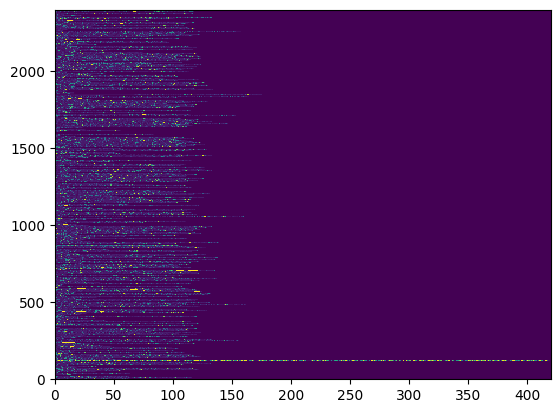

In [13]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * reviews.shape[0]
input_word_ids = tf.concat([cls, reviews], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

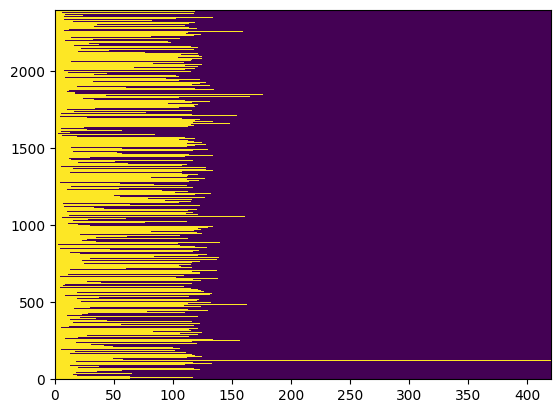

In [14]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

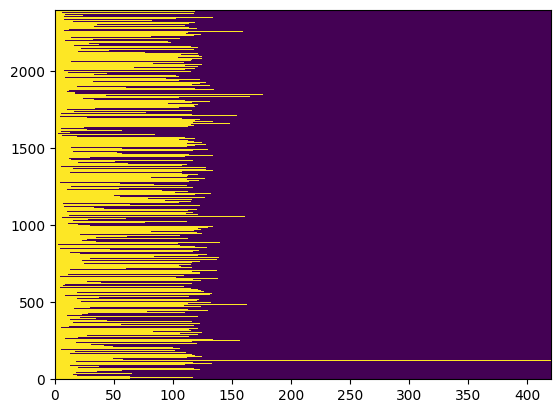

In [15]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.ones_like(reviews)
input_type_ids = tf.concat([type_cls, type_s1], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

A codificação do texto acima ainda não está totalmente preparada para ser entregue como entrada ao modelo BERT. Ainda é necessário:


*   Incluir o símbolo especial [CLS]
*   Fazer o padding das sentenças para manter um tamanho único e facilitar o treino
*   Incluir uma máscara para diferenciar tokens da sentença dos tokens especiais e de padding
*   Incluir umamáscara especial para posição de cada token na sequência



In [16]:
def bert_encode(review, tokenizer):
  num_examples = len(review['reviews'])

  review = tf.ragged.constant([
      encode_sentence(s[:max_sent_length], tokenizer)
      for s in review["reviews"]
  ])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * review.shape[0]
  input_word_ids = tf.concat([cls, review], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.ones_like(review)

  input_type_ids = tf.concat(
      [type_cls, type_s1], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

reviews_train_enc = bert_encode(reviews_train, tokenizer)
reviews_train_labels = np.array(reviews_train['labels'])

reviews_validation_enc = bert_encode(reviews_validation, tokenizer)
reviews_validation_labels = np.array(reviews_validation['labels'])

reviews_test_enc = bert_encode(reviews_test, tokenizer)
reviews_test_labels  = np.array(reviews_test['labels'])

## O modelo

### Construir o modelo

O primeiro passo é baixar a configuração do modelo pré-treinado.

In [17]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

O `config` define o modelo BERT principal, que é um modelo Keras para prever as saídas de `num_classes` a partir das entradas com comprimento máximo de sequência `max_seq_length`.

Esta função retorna tanto o codificador quanto o classificador.

In [18]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

O classificador tem três entradas e uma saída:

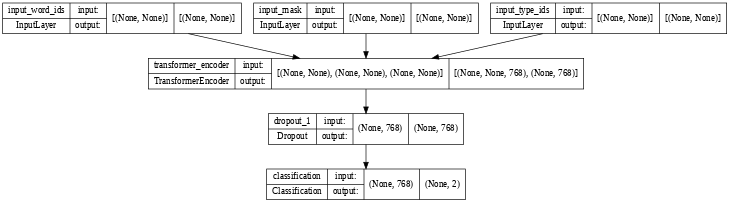

In [19]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

Execute-o em um lote de teste de dados 10 exemplos do conjunto de treinamento. A saída são os logits para as duas classes:

In [20]:
review_batch = {key: val[:10] for key, val in reviews_train_enc.items()}

bert_classifier(
    review_batch, training=True
).numpy()

array([[ 0.2115911 , -0.24855465],
       [ 0.10036419, -0.09122137],
       [ 0.16899535, -0.19916691],
       [ 0.1317656 , -0.16483155],
       [ 0.16875696, -0.39044064],
       [ 0.202824  ,  0.04597931],
       [ 0.0782506 , -0.15510502],
       [ 0.32521594, -0.1456838 ],
       [ 0.18930557, -0.45842552],
       [ 0.14863804, -0.05547668]], dtype=float32)

O `TransformerEncoder` no centro do classificador acima **é** o `bert_encoder`.

Inspecionando o codificador, vemos sua pilha de camadas `Transformer` conectadas a essas mesmas três entradas:

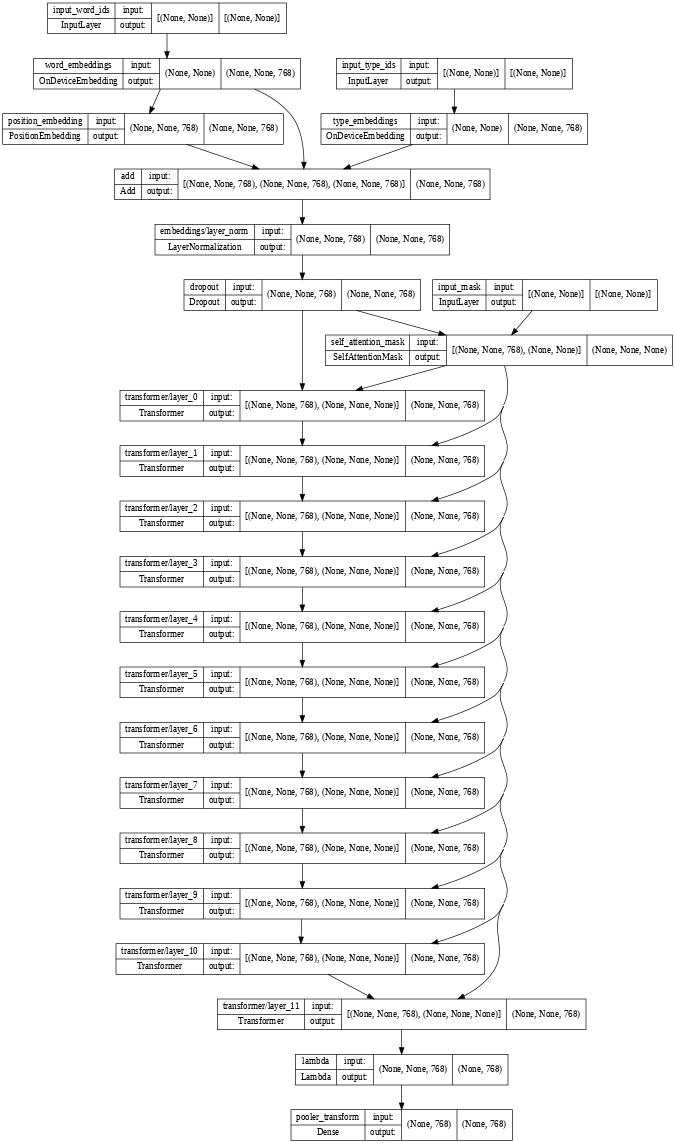

In [21]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

### Restaurar os pesos do codificador

Quando construído, o codificador é inicializado aleatoriamente. Restaurar os pesos do codificador do ponto de verificação:

In [22]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Observação: o `TransformerEncoder` pré-treinado também está disponível no [TensorFlow Hub](https://tensorflow.org/hub). Veja o [apêndice do Hub](#hub_bert) para detalhes.

### Configure o otimizador

BERT adota o otimizador Adam com decaimento de peso (também conhecido como "[AdamW](https://arxiv.org/abs/1711.05101)").
Ele também emprega um cronograma de taxa de aprendizado que primeiro aquece de 0 e então decai para 0.

In [23]:
# Set up epochs and steps
epochs = 10
batch_size = 32
eval_batch_size = 32

train_data_size = len(reviews_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Isso retorna um otimizador `AdamWeightDecay` com o cronograma de taxa de aprendizado definido:

In [24]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

Para ver um exemplo de como personalizar o otimizador e sua programação, consulte o [Apêndice de programação do otimizador](#optiizer_schedule).

### Treine o modelo

A métrica é a precisão e usamos entropia cruzada categórica esparsa como perda.

In [25]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      reviews_train_enc, reviews_train_labels,
      validation_data=(reviews_validation_enc, reviews_validation_labels),
      batch_size=batch_size,
      epochs=epochs)

Epoch 1/10
75/75 [==============================] - 3422s 46s/step - loss: 0.6961 - accuracy: 0.5496 - val_loss: 0.5904 - val_accuracy: 0.7300
Epoch 2/10
75/75 [==============================] - 3462s 46s/step - loss: 0.4695 - accuracy: 0.7850 - val_loss: 0.4986 - val_accuracy: 0.7875
Epoch 3/10
75/75 [==============================] - 3405s 45s/step - loss: 0.2969 - accuracy: 0.8842 - val_loss: 0.4846 - val_accuracy: 0.7962
Epoch 4/10
75/75 [==============================] - 3416s 46s/step - loss: 0.1942 - accuracy: 0.9308 - val_loss: 0.5720 - val_accuracy: 0.7975
Epoch 5/10
75/75 [==============================] - 3459s 46s/step - loss: 0.1052 - accuracy: 0.9658 - val_loss: 0.6874 - val_accuracy: 0.8150
Epoch 6/10
75/75 [==============================] - 3426s 46s/step - loss: 0.0663 - accuracy: 0.9787 - val_loss: 0.8100 - val_accuracy: 0.7987
Epoch 7/10
75/75 [==============================] - 3350s 45s/step - loss: 0.0444 - accuracy: 0.9892 - val_loss: 0.8781 - val_accuracy: 0.8100

Agora execute o modelo ajustado em um exemplo personalizado para ver se funciona.

Comece codificando alguns pares de frases:

O modelo deve relatar a classe `1` "correspondência" para o primeiro exemplo e a classe `0` "sem correspondência" para o segundo:

In [36]:
result_prob = bert_classifier(reviews_test_enc, training=False)

result = tf.argmax(result_prob, axis=1).numpy()

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Gerar matriz de confusão
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Matriz de Confusão')
    plt.xlabel('Classe Predita')
    plt.ylabel('Classe Verdadeira')
    plt.show()

# Gerar curva ROC
def plot_roc_curve(y_true, y_pred_prob):
    # Calcular fpr, tpr e auc para a classe positiva
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plotar a curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Curva ROC')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

Relatório de classificação:
                 precision    recall  f1-score   support

não recomendado       0.81      0.80      0.81       400
    recomendado       0.81      0.82      0.81       400

       accuracy                           0.81       800
      macro avg       0.81      0.81      0.81       800
   weighted avg       0.81      0.81      0.81       800



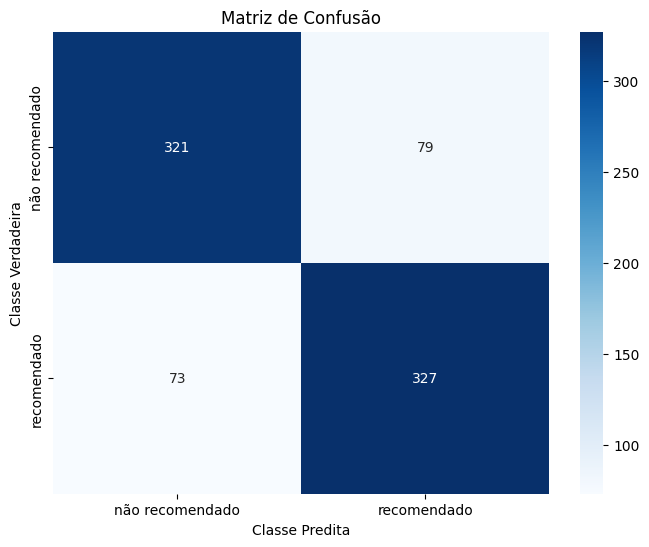

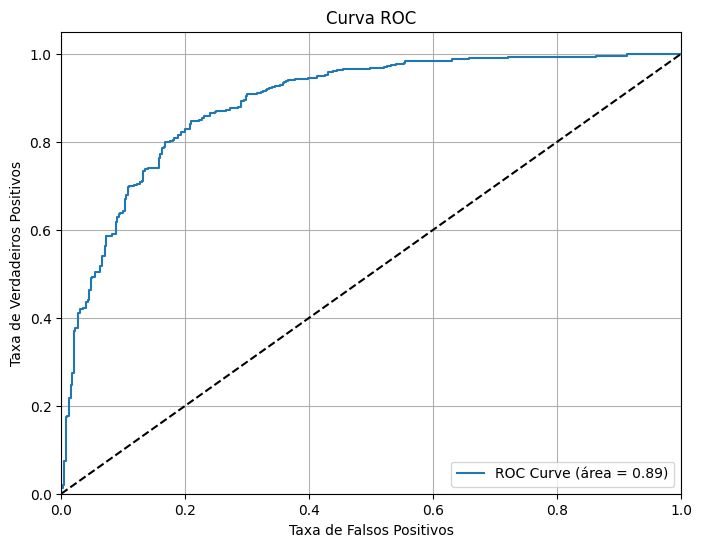

In [38]:
from sklearn.metrics import classification_report

print("Relatório de classificação:")
print(classification_report(reviews_test_labels, result, target_names=['não recomendado', 'recomendado']))

plot_confusion_matrix(reviews_test_labels, result, ['não recomendado', 'recomendado'])

plot_roc_curve(reviews_test_labels, result_prob)

### Salve o modelo

Frequentemente, o objetivo de treinar um modelo é _usá-lo_ para algo, então exporte o modelo e restaure-o para ter certeza de que ele funciona.

In [29]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)